In [1]:
#######################################
#### Code for the city selection ######
#######################################

#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import warnings
import geopandas as gpd
import xarray as xr
import numpy as np
import geopy
import geopy.distance
import os
import earthpy as et
import pickle

#for calculating distance to the coast
from scipy.spatial import cKDTree
from shapely.geometry import Point

#for adding in the closest urban area
import heapq
import operator

#load starting dataset (United Nations data)
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Excels'))
#df = pd.read_excel(r'citys_for_python_import.xlsx')
df = pd.read_excel(r'all_cities_300k_greater.xlsx')
# look at cities under 40deg N latitude < 40
df=df[df['Latitude'] < 40]
# look at cities with population of under 1 million in 2015
df=df[df[2015]< 1000]
#transfrom into geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [9]:
# add in the distance to the coastline

# load in the dataset
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','txt_files','dist2coast_folder'))
dist2coast = pd.read_csv(r'dist2coast.txt', sep="\t", header=None)
dist2coast.columns = ['Longitude', 'Latitude', 'Distance']

#transfrom into geopandas dataframe
g_dist2coast = gpd.GeoDataFrame(dist2coast, geometry=gpd.points_from_xy(dist2coast.Longitude, dist2coast.Latitude))

#define function for calculating distance to coastline
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

#add in the distance to coastline
gdf2 = ckdnearest(gdf, g_dist2coast)

# remove the duplicate columns from the merge (lat, lon)

#function to rename duplicate columns
class renamer():
    def __init__(self):
        self.d = dict()

    def __call__(self, x):
        if x not in self.d:
            self.d[x] = 0
            return x
        else:
            self.d[x] += 1
            return "%s_%d" % (x, self.d[x])
        
#rename duplicate columns
gdf2 = gdf2.rename(columns=renamer())
#remove duplicate columns
gdf2 = gdf2.drop(columns = ["Latitude_1", "Longitude_1"])



In [73]:
# add in the lakes/ water bodies

#read in the dataset
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','lakes'))
lakes = xr.open_dataset('globolakes-static_distance_to_land_Map-300m-P5Y-2005-ESACCI_WB-fv1.0.nc')

#function to check the distance from the max point in the water body to the shore. 
#If the water body is more than 1km (ie 500m to shore) than is say it is a lake
#med_lake ≥ 0.1 km2 and dis to shore > 0.5km
#large_lake dis to shore 3km (6km)

def check_lake(x):
    if x >= 3:
        answer = 'large_lake'
    elif x > 0.5:
        answer = 'med_lake'
    else:
        answer = 'no_lake'
    return answer

lake_check = []
for i in range(len(gdf2)):
    
    min_lon = (gdf2.Longitude - 0.2).values[i]
    max_lon = (gdf2.Longitude + 0.2).values[i]
    min_lat = (gdf2.Latitude - 0.2).values[i]
    max_lat = (gdf2.Latitude + 0.2).values[i]

    lakesds2 = lakes.sel(lon = slice(min_lon, max_lon))
    lakesds3 = lakesds2.sel(lat = slice(max_lat, min_lat))

    x = lakesds3.distance_to_land.max().values
    
    
    lake_check.append(check_lake(x))
       
#check for very large lakes at a further distance
def check_big_water(x):
    if x >= 25:
        answer = 'big_water'
    else:
        answer = 'no_water'
    return answer

big_water_check = []
for i in range(len(gdf2)):
    
    min_lon = (gdf2.Longitude - 0.5).values[i]
    max_lon = (gdf2.Longitude + 0.5).values[i]
    min_lat = (gdf2.Latitude - 0.5).values[i]
    max_lat = (gdf2.Latitude + 0.5).values[i]

    lakesds2 = lakes.sel(lon = slice(min_lon, max_lon))
    lakesds3 = lakesds2.sel(lat = slice(max_lat, min_lat))

    x = lakesds3.distance_to_land.max().values
    
    
    big_water_check.append(check_big_water(x))
    
#Add lake info onto the main data 
gdf2["Lake"] = lake_check
gdf2["Big_water"] = big_water_check

In [74]:
# Add in std elevation to see if plateau

#read in elevation data
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Elevation'))
elevation = xr.open_dataset('data.nc')

topo = elevation['topo']

max_elevation = []
min_elevation = []
mean_elevation = []
std_dev = []
range_elevation = []

for i in range(len(gdf2)):
    
    min_lon = (gdf2.Longitude - 0.25).values[i]
    max_lon = (gdf2.Longitude + 0.25).values[i]
    min_lat = (gdf2.Latitude - 0.25).values[i]
    max_lat = (gdf2.Latitude + 0.25).values[i]

    # topo X is longitude, Y is latitude 
    topo2 = topo.sel(X = slice(min_lon, max_lon), Y = slice(max_lat, min_lat))

    topo_max = topo2.max().values.tolist()
    topo_min = topo2.min().values.tolist()
    topo_mean = topo2.mean().values.tolist()
    topo_std_dev = np.std(topo2).values.tolist()
    topo_range = topo_max - topo_min

    max_elevation.append(topo_max)
    min_elevation.append(topo_min)
    mean_elevation.append(topo_mean)
    std_dev.append(topo_std_dev)
    range_elevation.append(topo_range)

# check that range no more than 5 std deviations
Elevation_type = []
for i in range(len(std_dev)):
    if std_dev[i] < (1/5) * range_elevation[i]:
        ele_type = "Flat"
    else:
        ele_type = "Hilly"
    
    Elevation_type.append(ele_type)    

#Add elevation columns into main dataset
gdf2['max_elevation'] = max_elevation
gdf2['min_elevation'] = min_elevation
gdf2['mean_elevation'] = mean_elevation
gdf2['std_dev_elevation'] = std_dev
gdf2['range_elevation'] = range_elevation
gdf2['Elevation_type'] = Elevation_type    
    

In [75]:
#proximity to other urban areas
#check against dataset of all urban areas with population greater then 300,000
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Excels'))
all_cities = pd.read_excel('all_cities_300k_greater.xlsx')

gdf2["Nearest_city"] = 'null'
gdf2["Urban_dist"] = 'null'

for i in range(len(gdf2)):
    coords_1 = (gdf2.Latitude.iloc[i], gdf2.Longitude.iloc[i])
    Distance = []
    
    for n in range(len(all_cities)):
        coords_2 = (all_cities.Latitude.iloc[n], all_cities.Longitude.iloc[n])
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        Distance.append(dist)
        
    all_cities["Urban_dist"] = Distance
    smallest_2 = heapq.nsmallest(2, enumerate(all_cities["Urban_dist"]),key=operator.itemgetter(1)) 
    #look at smallest 2 as the smallest one is going to be the city itself
   
    gdf2["Nearest_city"].iloc[i] = all_cities.iloc[smallest_2[1][0]]["Urban Agglomeration"]
    gdf2["Urban_dist"].iloc[i] = all_cities.iloc[smallest_2[1][0]]["Urban_dist"]    
    
gdf2 = gdf2.rename(columns={"Urban Agglomeration": "Urban_Agglomeration"})

In [8]:
#######################################################
###### looking at differenct selection critera ########
#######################################################

coastal_distance = 100
lake_type = 'no_lake'       # this is checked for ~20km from city centre
                            #options 'large_lake' : more than 6km length
                            #        'med_lake' : between 1 and 6km in length
large_water = 'no_water'    #water bodies greater than 50km in length checked for ~50km from city centre
std_elevation_ubound =  150
other_city_dist = 42

gdf3 = gdf2.copy()
city_selection_1 = gdf3[(gdf3['Distance'] >= coastal_distance) & (gdf3['Lake'] == lake_type) & (gdf3['Big_water'] == 
        large_water) & (gdf3['std_dev_elevation'] <= std_elevation_ubound)& (gdf3['Urban_dist'] > other_city_dist)].copy()

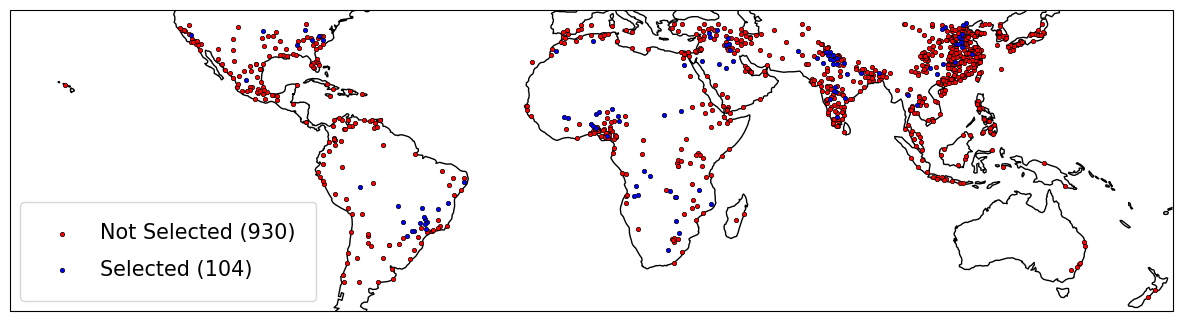

In [158]:
#cities chosen and those consider
selected = city_selection_area_removed.copy()
non_selected = gdf3[~gdf3['Urban_Agglomeration'].isin(city_selection['Urban_Agglomeration'])].copy()

fig = plt.figure(figsize=(15,10))

selected_lats = selected['Latitude']
selected_lons = selected['Longitude']

non_selected_lats = non_selected['Latitude']
non_selected_lons = non_selected['Longitude']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()


ax.scatter(non_selected_lons, non_selected_lats, zorder=5,color='red', label='Not Selected ({})'.format(len(non_selected))
           , linewidths =0.5, s =10,edgecolor = 'black')
ax.scatter(selected_lons, selected_lats, zorder=5,color='blue', label='Selected ({})'.format(len(selected)), 
           linewidths =0.5, s =10,edgecolor = 'black')

ax.legend(loc=3, borderpad = 1, fontsize = 15, labelspacing=0.8)

#save the plot as a png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'UEA', 'Urban_Heat', 'PROJECT','City_Selection','Selection_Images'))
plt.savefig('final_cities_2_std100_small_dots.png')